In [82]:
data_path = r"C:\Users\MainUser\project\cs224w_cb_graph\graphs_ffr_delta\graph_0240.pt"
data = torch.load(data_path, weights_only=False)
print(data["speech"].x)
print("Num speech nodes:", data["speech"].x.shape[0])
for i in range(data["speech"].x.shape[0]):
    print(
        f"speech {i}: date={data['speech'].date[i]}, "
        f"Δ={float(data['speech'].x[i, -1]):.6f}"
    )

tensor([[-5.6771e-02,  1.2027e-01, -1.4692e-02,  ...,  2.3600e+02,
          2.1000e+01, -9.2627e-04],
        [-6.5898e-02,  7.4094e-02, -4.0092e-02,  ...,  2.3200e+02,
          2.9000e+01,  1.1333e-03],
        [-7.3008e-02,  4.5059e-02, -4.8298e-02,  ...,  2.3300e+02,
          2.7000e+01,  2.4981e-03],
        ...,
        [-5.1391e-02,  1.1932e-01, -3.4272e-02,  ...,  2.4000e+02,
          0.0000e+00,  0.0000e+00],
        [-4.3836e-02,  1.0551e-01, -3.1730e-02,  ...,  2.3400e+02,
          2.6000e+01, -3.6947e-03],
        [-4.1282e-02,  1.2390e-01, -2.8635e-02,  ...,  2.3700e+02,
          2.0000e+01, -2.0110e-03]])
Num speech nodes: 14
speech 0: date=2021-03-02 00:00:00, Δ=-0.000926
speech 1: date=2021-02-22 00:00:00, Δ=+0.001133
speech 2: date=2021-02-24 00:00:00, Δ=+0.002498
speech 3: date=2021-02-24 00:00:00, Δ=+0.002498
speech 4: date=2021-02-25 00:00:00, Δ=-0.003695
speech 5: date=2021-03-01 00:00:00, Δ=+0.000121
speech 6: date=2021-03-02 00:00:00, Δ=-0.000926
speech 7: d

In [98]:
def visualize_graph_timeline(data, show_reverse_edges=False, show_follows=True):
    """
    Visual timeline visualization:
      - Automatically detect date d from speech nodes
      - Highlight speech node(s) at date d
      - Bigger speech nodes
      - Cleaned labels (remove 00:00:00)
      - Straight edges
    """

    import networkx as nx
    import matplotlib.pyplot as plt
    import numpy as np
    from datetime import datetime

    G = nx.DiGraph()

    # --------------------------------------------------------
    # 1. Add nodes
    # --------------------------------------------------------
    for ntype in data.node_types:
        for i in range(data[ntype].x.size(0)):
            G.add_node((ntype, i), ntype=ntype, idx=i)

    # --------------------------------------------------------
    # 2. Add edges
    # --------------------------------------------------------
    for etype in data.edge_types:
        src, rel, dst = etype

        if not show_reverse_edges and rel.startswith("rev_"):
            continue
        if not show_follows and rel == "follows":
            continue

        edge_index = data[etype].edge_index

        for j in range(edge_index.size(1)):
            s = edge_index[0, j].item()
            t = edge_index[1, j].item()
            G.add_edge((src, s), (dst, t), rel=rel)

    # --------------------------------------------------------
    # 3. Clean dates + detect d
    # --------------------------------------------------------
    speech_x = data["speech"].x.cpu().numpy()
    raw_dates = data["speech"].date
    clean_dates = [dt.replace(" 00:00:00", "") for dt in raw_dates]

    # Convert to datetime for comparisons
    dt_objs = [datetime.strptime(dt, "%Y-%m-%d") for dt in clean_dates]

    # d = largest speech date
    d_date = max(dt_objs)

    # find indices where speech date == d
    speech_at_d_indices = [i for i, dt in enumerate(dt_objs) if dt == d_date]

    # --------------------------------------------------------
    # 4. Build labels
    # --------------------------------------------------------
    labels = {}
    for node in G.nodes():
        ntype, idx = node

        if ntype == "speech":

            rc = float(speech_x[idx, -1]) * 100
            is_today = idx in speech_at_d_indices
            if is_today:
            # DO NOT PRINT Δ FOR SPEECH ON DAY d
                labels[node] = (
                f"{ntype.upper()}_{idx}\n"
                f"{clean_dates[idx]}"
            )
            else:
                labels[node] = (
                f"{ntype.upper()}_{idx}\n"
                f"{clean_dates[idx]}\n"
                f"Δ={rc:.4f} \n (bps)"
            )
        else:
            labels[node] = f"{ntype.upper()}_{idx}"

    # --------------------------------------------------------
    # 5. Layout speech nodes by time
    # --------------------------------------------------------
    pos = {}
    sorted_idx = np.argsort(dt_objs)
    SPEECH_SPACING = 4.0

    for rank, idx in enumerate(sorted_idx):
        pos[("speech", idx)] = np.array([rank * SPEECH_SPACING, 0.0])

    last_x = (len(sorted_idx) - 1) * SPEECH_SPACING

    # --------------------------------------------------------
    # 6. Topic nodes
    # --------------------------------------------------------
    if "topic" in data.node_types:
        T = data["topic"].x.size(0)
        TOPIC_Y = 10.0
        for i in range(T):
            pos[("topic", i)] = np.array([i * (last_x / max(1, T - 1)), TOPIC_Y])

    # --------------------------------------------------------
    # 7. Author nodes
    # --------------------------------------------------------
    if "author" in data.node_types:
        A = data["author"].x.size(0)
        AUTHOR_Y = -10.0
        for i in range(A):
            pos[("author", i)] = np.array([i * (last_x / max(1, A - 1)), AUTHOR_Y])

    # --------------------------------------------------------
    # 8. Day node
    # --------------------------------------------------------
    if "day" in data.node_types:
        pos[("day", 0)] = np.array([last_x + 8.0, 0.0])

    # --------------------------------------------------------
    # 9. Draw graph with highlight for date d
    # --------------------------------------------------------
    plt.figure(figsize=(28, 14))

    base_color = {
        "speech": "skyblue",
        "topic": "orange",
        "author": "lightgreen",
        "day": "yellow",
    }

    node_colors = []
    node_sizes = []

    for node in G.nodes():
        ntype, idx = node

        if ntype == "speech" and idx in speech_at_d_indices:
            node_colors.append("red")
            node_sizes.append(6600)
        elif ntype == "speech":
            node_colors.append("skyblue")
            node_sizes.append(6600)
        elif ntype == "author":
            node_colors.append("lightgreen")
            node_sizes.append(4600)
        else:
            node_colors.append(base_color[ntype])
            node_sizes.append(4600)

    nx.draw_networkx_nodes(
        G, pos, node_color=node_colors, node_size=node_sizes,
        edgecolors="black", linewidths=2
    )

    nx.draw_networkx_edges(
        G, pos, arrows=True, arrowstyle="-|>", width=0.8
    )

    nx.draw_networkx_labels(
        G, pos, labels=labels, font_size=10, font_color="black"
    )

    plt.title(f"Timeline Layout — Speech at Date (d) highlighted (d = {d_date.date()})", fontsize=18)
    plt.axis("off")
    #plt.show()
    plt.savefig("timeline_graph.png", dpi=300, bbox_inches="tight")

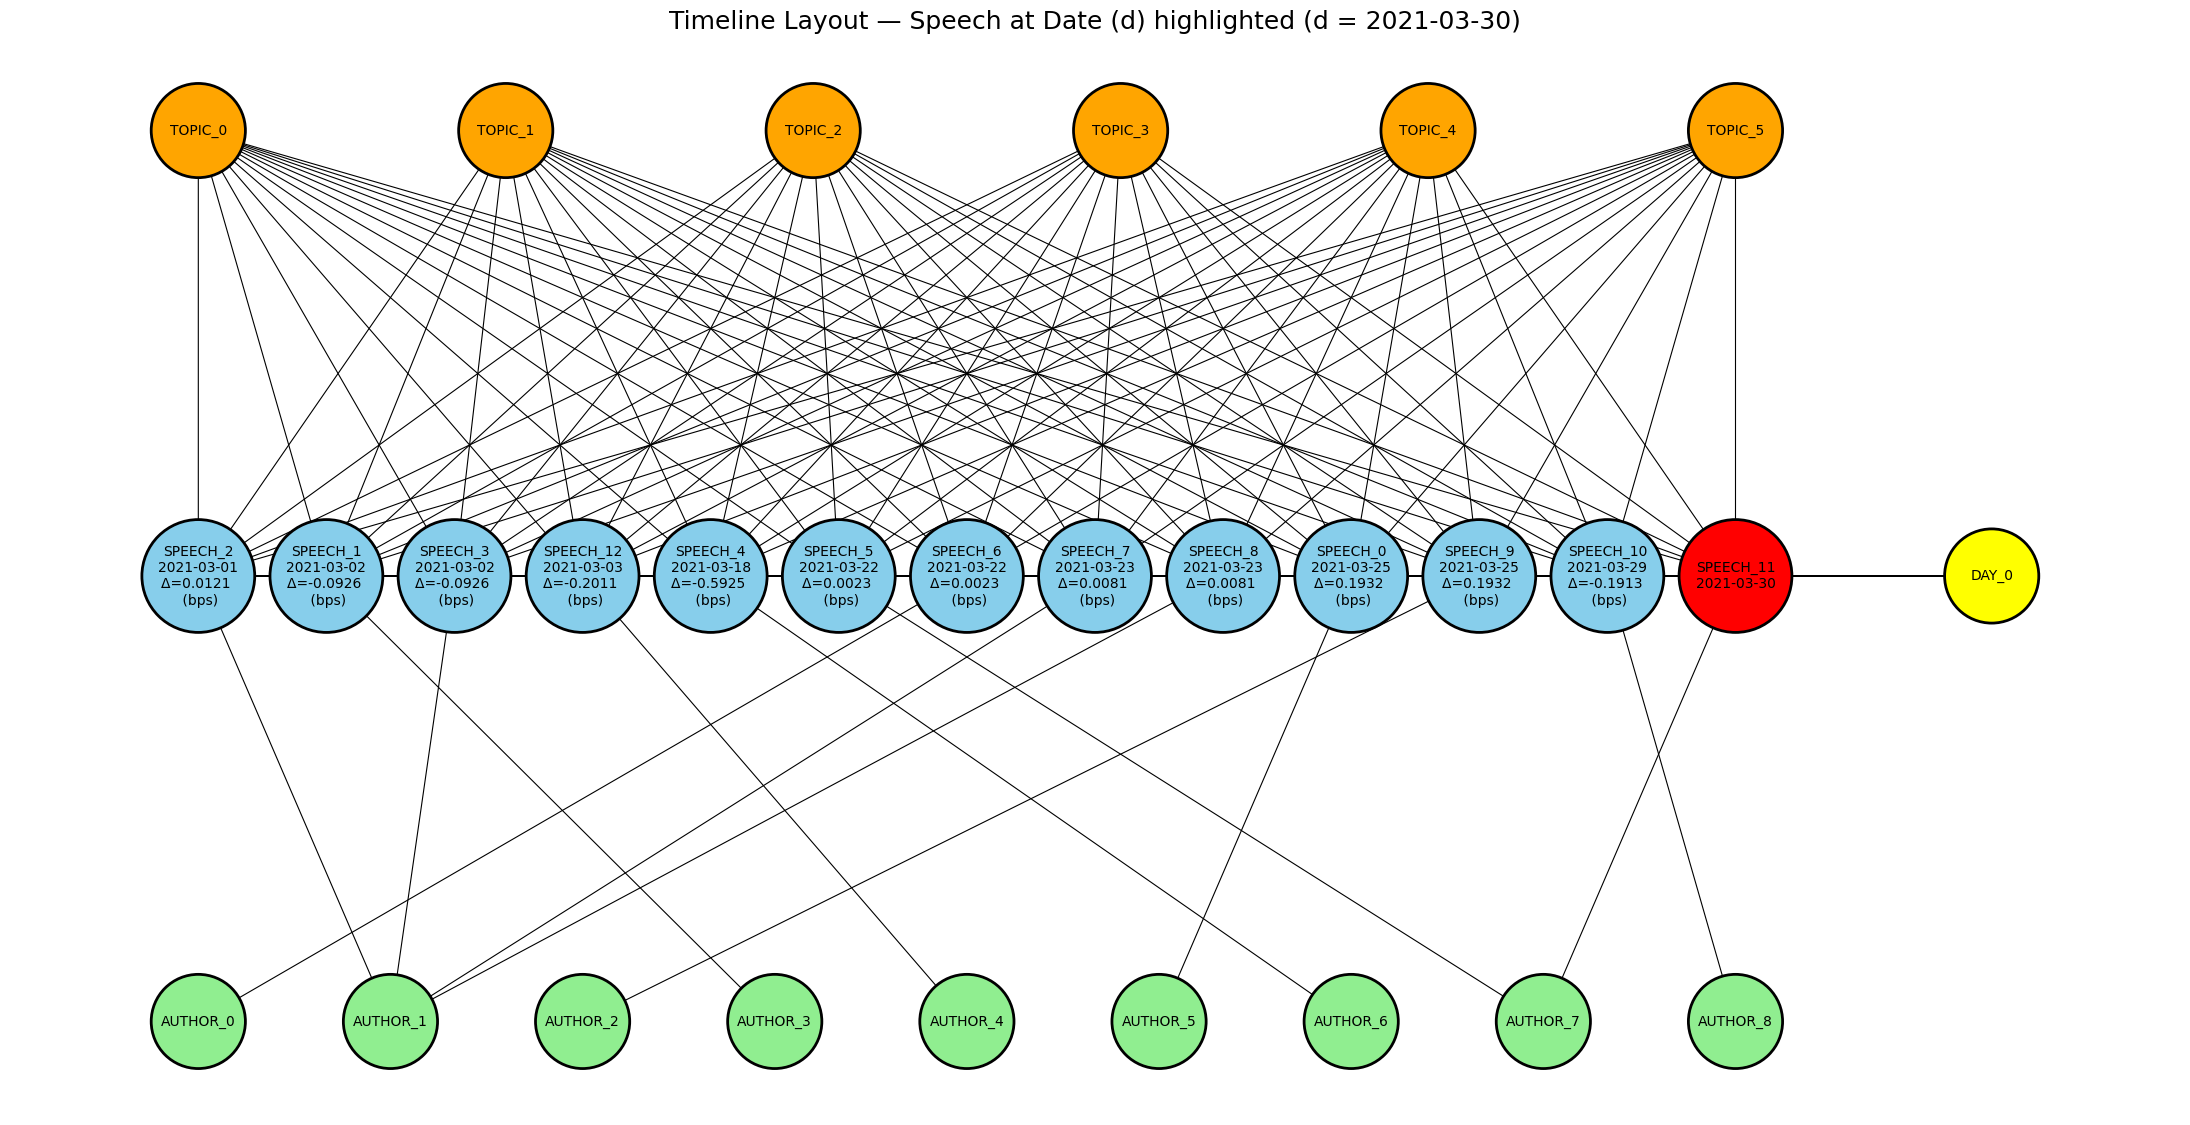

In [99]:
import torch
from torch.serialization import add_safe_globals
from torch_geometric.data import HeteroData

add_safe_globals([HeteroData])
data_path = r"C:\Users\MainUser\project\cs224w_cb_graph\graphs_ffr_delta\graph_0243.pt"
data = torch.load(data_path, weights_only=False)
visualize_graph_timeline(data)